In [50]:
# First import all neccessary libraries

import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [51]:
# Import the classification data

df_train = pd.read_csv('./data/dataset_1/AppML_InitialProject_train.csv')
df_test = pd.read_csv('./data/dataset_1/AppML_InitialProject_test_classification.csv')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# Define the target columns or "Y"
target_classification = "p_Truth_isElectron"  # Electron or not label
target_regression = "p_Truth_Energy"

# Define training and test sets
X = df_train.drop(columns=[target_classification, target_regression])  # df without label and energy columns
y = df_train[target_classification] # target columns

# Split train/test (e.g., 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train
model.fit(X_train, y_train)

# Predict probabilities on test set
y_pred_proba = model.predict_proba(X_test)[:, 1]  # probability of class 1 (electron)
y_pred = model.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:14:17] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9741
ROC AUC: 0.9952


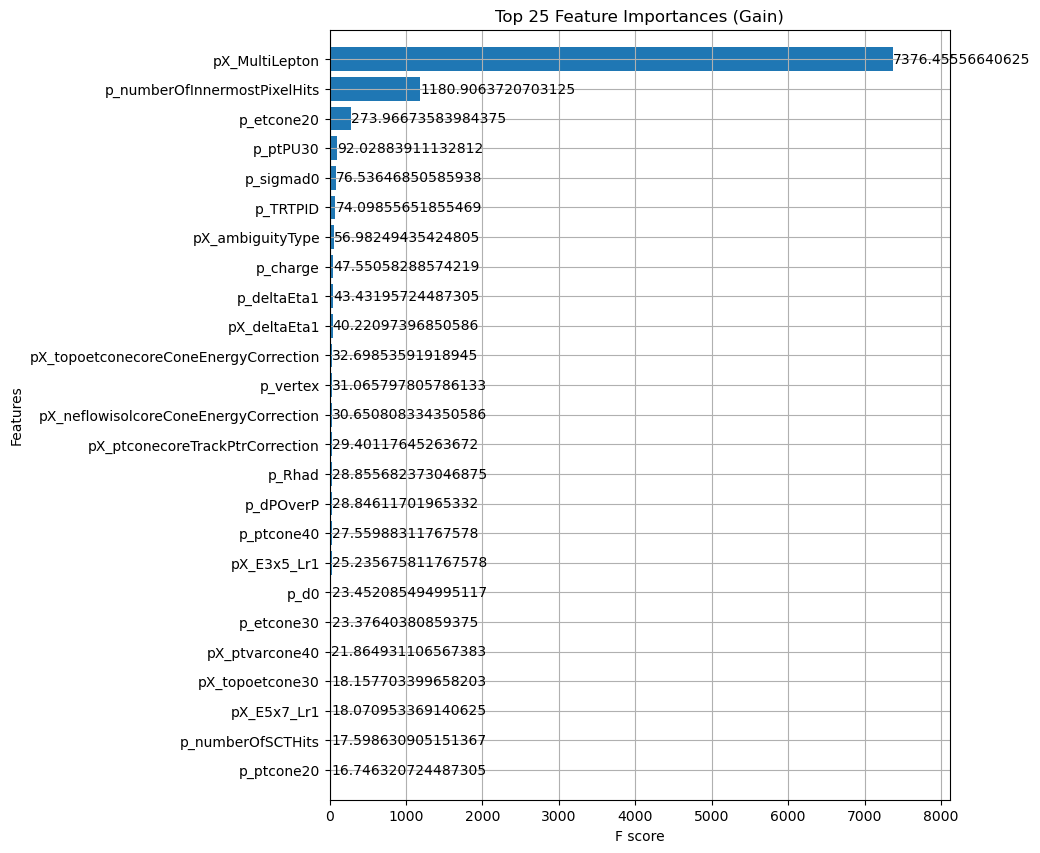

In [ ]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(8, 10))  # Wider and taller figure
xgb.plot_importance(model, max_num_features=25, importance_type='gain', height=0.8, ax=ax)
plt.title("Top 25 Feature Importances (Gain)")
plt.show()

It seems like the feature importance drops down quite rapidly, so let's take the top 10 as a cut off and train a smaller model.

In [ ]:
# Get feature importances (by gain)
importances = model.get_booster().get_score(importance_type='gain')

# Sort and select top 10 features
top_10_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_feature_names = [f[0] for f in top_10_features]

print("Top 10 features:", top_10_feature_names)

# Extract top 10 features
X_train_top10 = X_train[top_10_feature_names]
X_test_top10 = X_test[top_10_feature_names]

model_top10 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_top10.fit(X_train_top10, y_train)

y_pred_top10 = model_top10.predict(X_test_top10)
y_pred_proba_top10 = model_top10.predict_proba(X_test_top10)[:, 1]

acc_top10 = accuracy_score(y_test, y_pred_top10)
roc_auc_top10 = roc_auc_score(y_test, y_pred_proba_top10)

print(f"[Top 10 Features] Accuracy: {acc_top10:.4f}")
print(f"[Top 10 Features] ROC AUC: {roc_auc_top10:.4f}")

Top 10 features: ['pX_MultiLepton', 'p_numberOfInnermostPixelHits', 'p_etcone20', 'p_ptPU30', 'p_sigmad0', 'p_TRTPID', 'pX_ambiguityType', 'p_charge', 'p_deltaEta1', 'pX_deltaEta1']


/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:14:19] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[Top 10 Features] Accuracy: 0.9612
[Top 10 Features] ROC AUC: 0.9897


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import numpy as np

# Define base model
model_tune = xgb.XGBClassifier(eval_metric='logloss')

# Define the parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.3, 0.5, 1],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0.1, 1, 10]
}

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    model_tune,
    param_distributions=param_dist,
    n_iter=50,  # number of parameter settings sampled
    scoring='roc_auc',  # or 'accuracy'
    n_jobs=-1,  # use all cores
    cv=3,
    verbose=2,
    random_state=42
)

# Fit on your training data (change to top 10 features if needed)
random_search.fit(X_train_top10, y_train)

# Best model
best_model = random_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test_top10)
y_pred_proba = best_model.predict_proba(X_test_top10)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Best Parameters:\n", random_search.best_params_)
print(f"[Tuned Model] Accuracy: {acc:.4f}")
print(f"[Tuned Model] ROC AUC: {roc_auc:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=   1.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=   1.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=7, n_estimators=200, reg_alpha=10, reg_lambda=0.1, subsample=0.9; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=7, n_estimators=200, reg_alpha=10, reg_lambda=0.1, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, mi

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Split the training set into new train and validation sets
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train_top10, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Best params from RandomizedSearchCV
best_params = {
    'subsample': 0.7,
    'reg_lambda': 0.1,
    'reg_alpha': 10,
    'n_estimators': 300,
    'min_child_weight': 1,
    'max_depth': 6,
    'learning_rate': 0.05,
    'gamma': 0.3,
    'colsample_bytree': 0.6
}

# Define and train model with early stopping
model_tune_stop = xgb.XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss",
    early_stopping_rounds=10,
)

model_tune_stop.fit(
    X_train_small, y_train_small,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Final evaluation on test set
y_pred = model_tune_stop.predict(X_test_top10)
y_pred_proba = model_tune_stop.predict_proba(X_test_top10)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"[Early Stop + Tuned] Accuracy: {acc:.4f}")
print(f"[Early Stop + Tuned] ROC AUC: {roc_auc:.4f}")

[0]	validation_0-logloss:0.48797
[1]	validation_0-logloss:0.45875
[2]	validation_0-logloss:0.43290
[3]	validation_0-logloss:0.41001
[4]	validation_0-logloss:0.39294
[5]	validation_0-logloss:0.37354
[6]	validation_0-logloss:0.35709
[7]	validation_0-logloss:0.34155
[8]	validation_0-logloss:0.32856
[9]	validation_0-logloss:0.31518
[10]	validation_0-logloss:0.30227
[11]	validation_0-logloss:0.29280
[12]	validation_0-logloss:0.28220
[13]	validation_0-logloss:0.27200
[14]	validation_0-logloss:0.26252
[15]	validation_0-logloss:0.25395
[16]	validation_0-logloss:0.24579
[17]	validation_0-logloss:0.23759
[18]	validation_0-logloss:0.23029
[19]	validation_0-logloss:0.22328
[20]	validation_0-logloss:0.21762
[21]	validation_0-logloss:0.21222
[22]	validation_0-logloss:0.20656
[23]	validation_0-logloss:0.20174
[24]	validation_0-logloss:0.19737
[25]	validation_0-logloss:0.19243
[26]	validation_0-logloss:0.18824
[27]	validation_0-logloss:0.18379
[28]	validation_0-logloss:0.18025
[29]	validation_0-loglos

/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:15:01] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[48]	validation_0-logloss:0.13235
[49]	validation_0-logloss:0.13098
[50]	validation_0-logloss:0.12983
[51]	validation_0-logloss:0.12876
[52]	validation_0-logloss:0.12771
[53]	validation_0-logloss:0.12653
[54]	validation_0-logloss:0.12527
[55]	validation_0-logloss:0.12454
[56]	validation_0-logloss:0.12352
[57]	validation_0-logloss:0.12237
[58]	validation_0-logloss:0.12146
[59]	validation_0-logloss:0.12075
[60]	validation_0-logloss:0.11974
[61]	validation_0-logloss:0.11894
[62]	validation_0-logloss:0.11805
[63]	validation_0-logloss:0.11741
[64]	validation_0-logloss:0.11654
[65]	validation_0-logloss:0.11592
[66]	validation_0-logloss:0.11521
[67]	validation_0-logloss:0.11449
[68]	validation_0-logloss:0.11394
[69]	validation_0-logloss:0.11329
[70]	validation_0-logloss:0.11283
[71]	validation_0-logloss:0.11218
[72]	validation_0-logloss:0.11166
[73]	validation_0-logloss:0.11123
[74]	validation_0-logloss:0.11081
[75]	validation_0-logloss:0.11026
[76]	validation_0-logloss:0.10974
[77]	validatio

Top 25 features: ['pX_MultiLepton', 'p_numberOfInnermostPixelHits', 'p_etcone20', 'p_ptPU30', 'p_sigmad0', 'p_TRTPID', 'pX_ambiguityType', 'p_charge', 'p_deltaEta1', 'pX_deltaEta1', 'pX_topoetconecoreConeEnergyCorrection', 'p_vertex', 'pX_neflowisolcoreConeEnergyCorrection', 'pX_ptconecoreTrackPtrCorrection', 'p_Rhad', 'p_dPOverP', 'p_ptcone40', 'pX_E3x5_Lr1', 'p_d0', 'p_etcone30', 'pX_ptvarcone40', 'pX_topoetcone30', 'pX_E5x7_Lr1', 'p_numberOfSCTHits', 'p_ptcone20']


/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:15:03] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[Tuned] Accuracy: 0.9723
[Tuned] ROC AUC: 0.9945
[0]	validation_0-logloss:0.48314	validation_1-logloss:0.48024
[1]	validation_0-logloss:0.45326	validation_1-logloss:0.45089
[2]	validation_0-logloss:0.42749	validation_1-logloss:0.42548
[3]	validation_0-logloss:0.40511	validation_1-logloss:0.40342
[4]	validation_0-logloss:0.38526	validation_1-logloss:0.38390
[5]	validation_0-logloss:0.36673	validation_1-logloss:0.36568
[6]	validation_0-logloss:0.34963	validation_1-logloss:0.34883
[7]	validation_0-logloss:0.33546	validation_1-logloss:0.33488
[8]	validation_0-logloss:0.32127	validation_1-logloss:0.32087
[9]	validation_0-logloss:0.30748	validation_1-logloss:0.30735
[10]	validation_0-logloss:0.29477	validation_1-logloss:0.29485
[11]	validation_0-logloss:0.28278	validation_1-logloss:0.28311
[12]	validation_0-logloss:0.27176	validation_1-logloss:0.27230
[13]	validation_0-logloss:0.26150	validation_1-logloss:0.26220
[14]	validation_0-logloss:0.25196	validation_1-logloss:0.25281
[15]	validation_

/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:15:04] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-logloss:0.19024	validation_1-logloss:0.19192
[24]	validation_0-logloss:0.18505	validation_1-logloss:0.18683
[25]	validation_0-logloss:0.17991	validation_1-logloss:0.18178
[26]	validation_0-logloss:0.17530	validation_1-logloss:0.17726
[27]	validation_0-logloss:0.17101	validation_1-logloss:0.17310
[28]	validation_0-logloss:0.16682	validation_1-logloss:0.16902
[29]	validation_0-logloss:0.16294	validation_1-logloss:0.16524
[30]	validation_0-logloss:0.15918	validation_1-logloss:0.16154
[31]	validation_0-logloss:0.15582	validation_1-logloss:0.15824
[32]	validation_0-logloss:0.15246	validation_1-logloss:0.15498
[33]	validation_0-logloss:0.14930	validation_1-logloss:0.15188
[34]	validation_0-logloss:0.14620	validation_1-logloss:0.14885
[35]	validation_0-logloss:0.14321	validation_1-logloss:0.14590
[36]	validation_0-logloss:0.14049	validation_1-logloss:0.14329
[37]	validation_0-logloss:0.13805	validation_1-logloss:0.14094
[38]	validation_0-logloss:0.13570	validation_1-logloss:

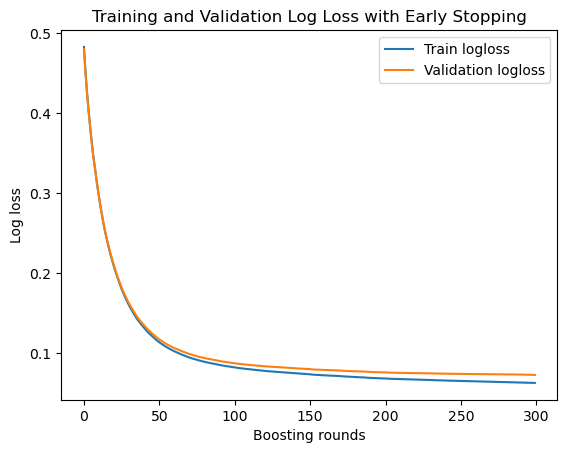

In [ ]:
# Get feature importances (by gain)
importances = model.get_booster().get_score(importance_type='gain')

# Sort and select top 10 features
top_25_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:25]
top_25_feature_names = [f[0] for f in top_25_features]

print("Top 25 features:", top_25_feature_names)

# Split data into train + validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract top 10 features
X_train = X_train[top_25_feature_names]
X_val = X_val[top_25_feature_names]

# Model A: No early stopping
model_a = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
model_a.fit(X_train, y_train)

y_pred = model_a.predict(X_val)
y_pred_proba = model_a.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f"[Tuned] Accuracy: {acc:.4f}")
print(f"[Tuned] ROC AUC: {roc_auc:.4f}")


from sklearn.preprocessing import LabelEncoder
# Encode string labels to integers
le = LabelEncoder()
y_train_full_num = le.fit_transform(y_train)
y_val_num = le.transform(y_val)

model_b = xgb.XGBClassifier(**best_params, use_label_encoder=False, early_stopping_rounds=10, eval_metric='logloss')

eval_set = [(X_train, y_train_full_num), (X_val, y_val_num)]
model_b.fit(
    X_train, y_train_full_num,
    eval_set=eval_set,
    verbose=True
)

y_pred = model_b.predict(X_val)
y_pred_proba = model_b.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f"[Early Stop + Tuned] Accuracy: {acc:.4f}")
print(f"[Early Stop + Tuned] ROC AUC: {roc_auc:.4f}")

# Plot results
results = model_b.evals_result()
epochs = len(results['validation_0']['logloss'])
plt.plot(range(epochs), results['validation_0']['logloss'], label='Train logloss')
plt.plot(range(epochs), results['validation_1']['logloss'], label='Validation logloss')
plt.xlabel('Boosting rounds')
plt.ylabel('Log loss')
plt.legend()
plt.title('Training and Validation Log Loss with Early Stopping')
plt.show()



In [ ]:
booster = model_b.get_booster()
dump = booster.get_dump(with_stats=True)
num_trees = len(dump)

total_leaves = 0
total_splits = 0
for tree in dump:
    # Count leaves and splits by parsing tree string
    leaves = tree.count("leaf=")
    splits = tree.count("\n") - leaves  # rough split count = lines minus leaves
    total_leaves += leaves
    total_splits += splits

print(f"Number of trees: {num_trees}")
print(f"Total leaves: {total_leaves}")
print(f"Total splits: {total_splits}")

# Total parameters ~ total_leaves (leaf weights) + total_splits (split conditions)
total_params = total_leaves + total_splits
print(f"Approximate total parameters: {total_params}")

model_b.save_model("xgb_model.json")

import os
size_bytes = os.path.getsize("xgb_model.json")
size_mb = size_bytes / (1024 * 1024)
print(f"Model size: {size_mb:.2f} MB")

Number of trees: 300
Total leaves: 11425
Total splits: 11125
Approximate total parameters: 22550
Model size: 1.30 MB


In [ ]:
import pandas as pd

# 1. Load the test dataset
test_df = pd.read_csv('./data/dataset_1/AppML_InitialProject_test_classification.csv')

# 2. Select the top 25 features (from earlier)
# Use the same top_25_feature_names list used in training
test_X = test_df[top_25_feature_names]

# 3. Make predictions
preds = model_b.predict_proba(test_X)[:, 1]  # Probability of class 1

# 4. Create the output DataFrame
submission_df = pd.DataFrame({
    'index': range(len(preds)),
    'predicted': preds
})

# 5. Save the prediction output
submission_df.to_csv('Classification_HusainManasawala_XGBoost.csv', index=False, header=False)

# 6. Save the top 25 variable names to a separate CSV
with open('Classification_HusainManasawala_XGBoost_VariableList.csv', 'w') as f:
    for feature in top_25_feature_names:
        f.write(f"{feature},\n")

print("✅ Output files created:")
print("- Classification_HusainManasawala_XGBoost.csv")
print("- Classification_HusainManasawala_XGBoost_VariableList.csv")


✅ Output files created:
- Classification_HusainManasawala_XGBoost.csv
- Classification_HusainManasawala_XGBoost_VariableList.csv


## Now a RandomForestClassifier

In [ ]:
import pandas as pd
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss

# 1. Import the classification data
df_train = pd.read_csv('./data/dataset_1/AppML_InitialProject_train.csv')
df_test = pd.read_csv('./data/dataset_1/AppML_InitialProject_test_classification.csv')

# Define the target columns or "Y"
target_classification = "p_Truth_isElectron"  # Electron or not label
target_regression = "p_Truth_Energy"

# Define training and test sets
X = df_train.drop(columns=[target_classification, target_regression])  # df without label and energy columns
y = df_train[target_classification] # target columns

# 2. Split train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Initial RF to get feature importances
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_base.fit(X_train, y_train)

feat_importances = pd.Series(rf_base.feature_importances_, index=X_train.columns)
top_25_features = feat_importances.nlargest(25).index.tolist()

print("Top 25 features:", top_25_features)

# Select only top 25 features
X_train_25 = X_train[top_25_features]
X_val_25 = X_val[top_25_features]

# 4. Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 16, 24],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
start_time = time.time()
grid_search.fit(X_train_25, y_train)
end_time = time.time()

print(f"GridSearchCV took {(end_time - start_time):.2f} seconds")

best_rf = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# 5. Evaluate on validation set
y_val_pred = best_rf.predict(X_val_25)
y_val_pred_proba = best_rf.predict_proba(X_val_25)

val_acc = accuracy_score(y_val, y_val_pred)
val_logloss = log_loss(y_val, y_val_pred_proba)

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Log Loss: {val_logloss:.4f}")

# 6. Save model to disk and get file size
model_filename = "random_forest_best.pkl"
with open(model_filename, 'wb') as f:
    pickle.dump(best_rf, f)

import os
model_size_MB = os.path.getsize(model_filename) / 1024**2
print(f"Saved model size: {model_size_MB:.3f} MB")

# 7. Plot CV results: accuracy mean and std for different params (optional)
results = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(10,5))
plt.errorbar(
    results['param_max_depth'].astype(int), 
    results['mean_test_score'], 
    yerr=results['std_test_score'], 
    fmt='o-', capsize=5)
plt.xlabel('max_depth')
plt.ylabel('Mean CV Accuracy')
plt.title('CV Accuracy vs max_depth')
plt.grid(True)
plt.show()


Top 25 features: ['pX_MultiLepton', 'pX_topoetcone30', 'p_etcone20', 'p_ptPU30', 'pX_topoetcone20', 'p_etcone30', 'p_ptcone40', 'p_etcone40', 'p_numberOfInnermostPixelHits', 'pX_etcone20', 'p_Rhad', 'p_TRTPID', 'p_sigmad0', 'p_numberOfPixelHits', 'p_ptcone30', 'p_Eratio', 'pX_deltaEta1', 'pX_ehad1', 'pX_etcone40', 'p_deltaEta1', 'pX_ptvarcone30', 'pX_ptcone30', 'pX_ptvarcone40', 'p_Rhad1', 'pX_etcone30']
Fitting 3 folds for each of 36 candidates, totalling 108 fits


KeyboardInterrupt: 

In [ ]:
# Retrain best model with training time and param count
from sklearn.ensemble import RandomForestClassifier
import time

# 1. Retrain with best params
best_params = grid_search.best_params_
best_rf_retrained = RandomForestClassifier(
    **best_params, random_state=42, n_jobs=-1
)

start_train = time.time()
best_rf_retrained.fit(X_train_25, y_train)
end_train = time.time()

train_duration = end_train - start_train

# 2. Count parameters (tree nodes + leaves)
total_nodes = sum(est.tree_.node_count for est in best_rf_retrained.estimators_)
total_leaves = sum(est.tree_.n_leaves for est in best_rf_retrained.estimators_)

# 3. Print results
print(f"\nRetraining Time (best model): {train_duration:.2f} seconds")
print(f"Total Number of Nodes (splits + leaves): {total_nodes}")
print(f"Total Number of Leaf Nodes: {total_leaves}")

from sklearn.metrics import roc_auc_score

y_val_pred_proba = best_rf.predict_proba(X_val_25)[:, 1]
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC AUC: {val_roc_auc:.4f}")



Retraining Time (best model): 15.52 seconds
Total Number of Nodes (splits + leaves): 1458776
Total Number of Leaf Nodes: 729488
Validation ROC AUC: 0.9885


In [ ]:
import pandas as pd

# Assuming best_rf is your trained best RandomForestClassifier
# Assuming top_25_features is the list of selected features

# Load test data
df_test = pd.read_csv('./data/dataset_1/AppML_InitialProject_test_classification.csv')

# Select top 25 features only
X_test_25 = df_test[top_25_features]

# Predict probabilities for class 1
y_pred_proba = best_rf.predict_proba(X_test_25)[:, 1]

# Create submission DataFrame
submission_df = pd.DataFrame({
    'index': range(len(y_pred_proba)),
    'predicted': y_pred_proba
})

# Save predictions CSV without index column (index from 0 included as column)
submission_df.to_csv('Classification_HusainManasawal_RandomForestClassifier.csv', index=False, header=False)

# Save top 25 feature list CSV
with open('Classification_HusainManasawala_RandomForestClassifier_VariableList.csv', 'w') as f:
    for feature in top_25_features:
        f.write(f"{feature},\n")

print("✅ Output files created:")
print("- Classification_HusainManasawal_RandomForestClassifier.csv")
print("- Classification_HusainManasawala_RandomForestClassifier_VariableList.csv")


✅ Output files created:
- Classification_HusainManasawal_RandomForestClassifier.csv
- Classification_HusainManasawala_RandomForestClassifier_VariableList.csv


## Next, an MLP

Top 25 features: ['pX_MultiLepton', 'pX_topoetcone30', 'p_etcone20', 'p_ptPU30', 'pX_topoetcone20', 'p_etcone30', 'p_ptcone40', 'p_etcone40', 'p_numberOfInnermostPixelHits', 'pX_etcone20', 'p_Rhad', 'p_TRTPID', 'p_sigmad0', 'p_numberOfPixelHits', 'p_ptcone30', 'p_Eratio', 'pX_deltaEta1', 'pX_ehad1', 'pX_etcone40', 'p_deltaEta1', 'pX_ptvarcone30', 'pX_ptcone30', 'pX_ptvarcone40', 'p_Rhad1', 'pX_etcone30']
Using device: cuda

Training with lr=0.001, dropout=0.1
Epoch 1/50 - Train Loss: 0.1413 - Val Loss: 0.1253
Epoch 2/50 - Train Loss: 0.1210 - Val Loss: 0.1179
Epoch 3/50 - Train Loss: 0.1160 - Val Loss: 0.1125
Epoch 4/50 - Train Loss: 0.1129 - Val Loss: 0.1120
Epoch 5/50 - Train Loss: 0.1115 - Val Loss: 0.1101
Epoch 6/50 - Train Loss: 0.1101 - Val Loss: 0.1114
Epoch 7/50 - Train Loss: 0.1084 - Val Loss: 0.1103
Epoch 8/50 - Train Loss: 0.1075 - Val Loss: 0.1068
Epoch 9/50 - Train Loss: 0.1069 - Val Loss: 0.1088
Epoch 10/50 - Train Loss: 0.1059 - Val Loss: 0.1085
Epoch 11/50 - Train Loss:

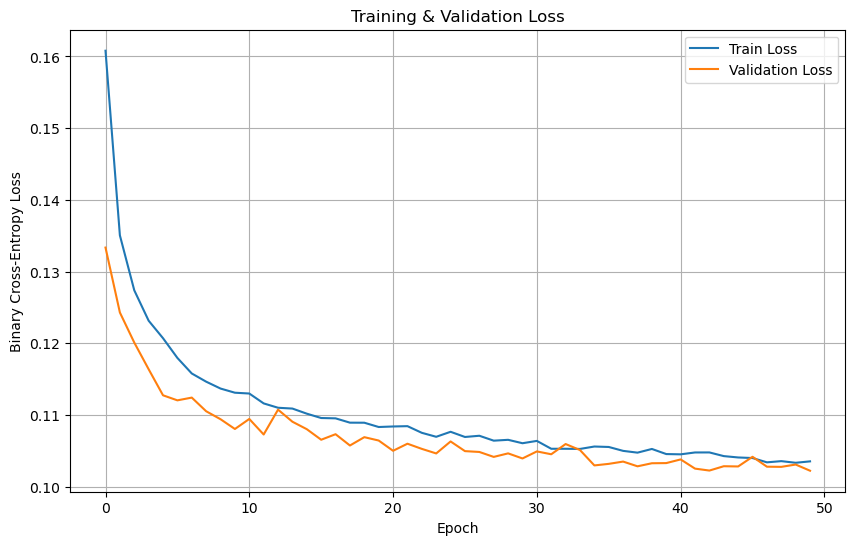

In [ ]:
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# 1. Load data
df_train = pd.read_csv('./data/dataset_1/AppML_InitialProject_train.csv')
target_classification = "p_Truth_isElectron"
target_regression = "p_Truth_Energy"

X = df_train.drop(columns=[target_classification, target_regression])
y = df_train[target_classification]

# 2. Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Select top 25 features by RF feature importance
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_base.fit(X_train, y_train)
feat_importances = pd.Series(rf_base.feature_importances_, index=X_train.columns)
top_25_features = feat_importances.nlargest(25).index.tolist()

print("Top 25 features:", top_25_features)

X_train_25 = X_train[top_25_features].values.astype(np.float32)
X_val_25 = X_val[top_25_features].values.astype(np.float32)

# Now scale, overwriting the same variables:
scaler = StandardScaler()
X_train_25 = scaler.fit_transform(X_train_25)
X_val_25 = scaler.transform(X_val_25)

y_train_np = y_train.values.astype(np.float32)
y_val_np = y_val.values.astype(np.float32)

# 4. Create PyTorch datasets and loaders
batch_size = 64
train_ds = TensorDataset(torch.from_numpy(X_train_25), torch.from_numpy(y_train_np))
val_ds = TensorDataset(torch.from_numpy(X_val_25), torch.from_numpy(y_val_np))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# 5. Define MLP model with ~20k params
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_p):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x).squeeze()

# Calculate approx params for given hidden_dim:

input_dim = 25
hidden_dim = 135 

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 6. Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    model.to(device)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        val_losses = []
        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    return history

# 7. Manual grid search for hyperparams (learning rate, dropout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

param_grid = {
    'lr': [1e-3, 5e-4],
    'dropout': [0.1, 0.3]
}

best_val_loss = float('inf')
best_params = None
best_model = None
best_history = None
best_train_time = None

criterion = nn.BCELoss()

for lr in param_grid['lr']:
    for dropout_p in param_grid['dropout']:
        print(f"\nTraining with lr={lr}, dropout={dropout_p}")
        model = MLP(input_dim, hidden_dim, dropout_p)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        start_time = time.time()
        history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, device=device)
        train_time = time.time() - start_time
        
        val_loss = history['val_loss'][-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = {'lr': lr, 'dropout': dropout_p}
            best_model = model
            best_history = history
            best_train_time = train_time

print("\nBest hyperparameters:", best_params)
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Training time of best model: {best_train_time:.2f} seconds")
print(f"Number of trainable parameters: {count_parameters(best_model)}")

# 8. Evaluate best model on validation set (accuracy, ROC AUC)
best_model.eval()
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val_25).to(device)
    y_val_preds = best_model(X_val_tensor).cpu().numpy()
    y_val_preds_label = (y_val_preds > 0.5).astype(int)

val_acc = accuracy_score(y_val_np, y_val_preds_label)
val_roc_auc = roc_auc_score(y_val_np, y_val_preds)

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation ROC AUC: {val_roc_auc:.4f}")

# 9. Save the best model
model_path = "mlp_best_model.pth"
torch.save(best_model.state_dict(), model_path)

import os
model_size_MB = os.path.getsize(model_path) / (1024**2)
print(f"Saved model size: {model_size_MB:.3f} MB")

# 10. Plot training and validation loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(best_history['train_loss'], label='Train Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 8. Retrain on full train+val dataset with best params
X_full = np.vstack([X_train_25, X_val_25])
y_full = np.hstack([y_train_np, y_val_np])
full_ds = TensorDataset(torch.from_numpy(X_full), torch.from_numpy(y_full))
full_loader = DataLoader(full_ds, batch_size=batch_size, shuffle=True)

model_final = MLP(input_dim, hidden_dim, best_params['dropout'])
model_final.to(device)

optimizer = torch.optim.Adam(model_final.parameters(), lr=best_params['lr'])
criterion = nn.BCELoss()

def train_final_model(model, train_loader, criterion, optimizer, epochs, device):
    print(f'Using devide: {device}')
    model.to(device)
    model.train()
    for epoch in range(epochs):
        epoch_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        print(f"Epoch {epoch+1}/{epochs} - Loss: {np.mean(epoch_losses):.4f}")

start_time = time.time()
train_final_model(model_final, full_loader, criterion, optimizer, epochs=50, device=device)
train_time_final = time.time() - start_time
print(f"Retraining on full data done in {train_time_final:.2f} seconds")

# 9. Evaluate best model on validation set (print val loss again)
model_final.eval()
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val_25).to(device)
    y_val_preds = model_final(X_val_tensor)
    val_loss_tensor = criterion(y_val_preds, torch.from_numpy(y_val_np).to(device)).item()

print(f"Validation loss of final retrained model (on val set): {val_loss_tensor:.4f}")

# 10. Predict on test set
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test_25).to(device)
    test_preds = model_final(X_test_tensor).cpu().numpy()

df_preds = pd.DataFrame({
    'index': df_test.index,
    'prediction_proba': test_preds
})

Using devide: cuda
Epoch 1/50 - Loss: 0.1577
Epoch 2/50 - Loss: 0.1329
Epoch 3/50 - Loss: 0.1256
Epoch 4/50 - Loss: 0.1222
Epoch 5/50 - Loss: 0.1192
Epoch 6/50 - Loss: 0.1169
Epoch 7/50 - Loss: 0.1152
Epoch 8/50 - Loss: 0.1139
Epoch 9/50 - Loss: 0.1130
Epoch 10/50 - Loss: 0.1135
Epoch 11/50 - Loss: 0.1122
Epoch 12/50 - Loss: 0.1114
Epoch 13/50 - Loss: 0.1099
Epoch 14/50 - Loss: 0.1109
Epoch 15/50 - Loss: 0.1094
Epoch 16/50 - Loss: 0.1088
Epoch 17/50 - Loss: 0.1095
Epoch 18/50 - Loss: 0.1090
Epoch 19/50 - Loss: 0.1083
Epoch 20/50 - Loss: 0.1085
Epoch 21/50 - Loss: 0.1084
Epoch 22/50 - Loss: 0.1079
Epoch 23/50 - Loss: 0.1067
Epoch 24/50 - Loss: 0.1069
Epoch 25/50 - Loss: 0.1073
Epoch 26/50 - Loss: 0.1066
Epoch 27/50 - Loss: 0.1070
Epoch 28/50 - Loss: 0.1063
Epoch 29/50 - Loss: 0.1059
Epoch 30/50 - Loss: 0.1069
Epoch 31/50 - Loss: 0.1056
Epoch 32/50 - Loss: 0.1057
Epoch 33/50 - Loss: 0.1056
Epoch 34/50 - Loss: 0.1053
Epoch 35/50 - Loss: 0.1057
Epoch 36/50 - Loss: 0.1056
Epoch 37/50 - Loss

In [54]:
df_preds.to_csv("Classification_HusainManasawala_PyTorchNN.csv", index=False, header=False)
print("Saved prediction probabilities to Classification_HusainManasawala_PyTorchNN.csv")

# 11. Save variable list
with open('Classification_HusainManasawala_PyTorchNN_VariableList.csv', 'w') as f:
    for feature in top_25_features:
        f.write(f"{feature},\n")
print("Saved variable list to Classification_HusainManasawala_PyTorchNN_VariableList.csv")

Saved prediction probabilities to Classification_HusainManasawala_PyTorchNN.csv
Saved variable list to Classification_HusainManasawala_PyTorchNN_VariableList.csv


In [55]:
# After hyperparameter grid search loop finishes:

print("\nBest hyperparameters found:")
print(f"Learning rate: {best_params['lr']}")
print(f"Dropout probability: {best_params['dropout']}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Training time of best model: {best_train_time:.2f} seconds")
print(f"Number of trainable parameters: {count_parameters(best_model)}")

# Then retrain on full train+val:
print("\nRetraining on full training + validation dataset with best hyperparameters...")



Best hyperparameters found:
Learning rate: 0.0005
Dropout probability: 0.3
Best validation loss: 0.1022
Training time of best model: 211.41 seconds
Number of trainable parameters: 40366

Retraining on full training + validation dataset with best hyperparameters...
